In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 決定木スクラッチ

深さ１の決定木クラスは⇩が最終形

In [2]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, max_depth=1, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.max_depth = max_depth
        
        self.left_node_class = None
        self.right_node_class = None
        
        self.best_gain = 0
        self.feature_id = None
        self.threshold = None
        
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        X, y = self._data_processing(X, y)
        
        num_iter = 0
        for col in range(X.shape[1]):
            for value in np.unique(X[:, col])[:-1]:
                is_left = (X[:, col] <= value)
                y_left = y[is_left]
                y_right = y[~is_left]

                gain = _gain(y_left, y_right)
                num_iter += 1
                
                if gain > self.best_gain:
                    self.best_gain = gain
                    self.feature_id = col
                    self.threshold = value
                    
                    left_node = y[is_left]
                    right_node = y[~is_left]
                    
                if self.verbose:
                    print("="*20)
                    print("iter:", num_iter)
                    print("best_gain:",  self.best_gain)            
                    print("feature_id:", self.feature_id)            
                    print("threshold:",  self.threshold) 
                    print("="*20)

        #葉ノードのクラスを記録する
        _, left_node_class_counts  = np.unique(left_node, return_counts=True)
        _, right_node_class_counts = np.unique(right_node, return_counts=True)

        self.left_node_class  = np.argmax(left_node_class_counts)
        self.right_node_class = np.argmax(right_node_class_counts)
        
        pass
    
    def _gini(self, y):
        """
        ジニ不純度を計算する
        """
        # 各クラス毎のサンプル数をセット
        _, labels_count = np.unique(y, return_counts=True) #[0, 1, 2], [15, 15, 15]
        labels_count_all = np.sum(labels_count) #45

        impurity = 1 - np.sum((labels_count / labels_count_all)**2)
        return impurity
    
    def _gain(self, y_left, y_right):
        """
        情報利得を計算する
        """
        parent_node = np.concatenate([y_left, y_right])

        num_left, num_right = len(y_left), len(y_right)
        num_all = num_left + num_right

        left_ratio, right_ratio = (num_left / num_all), (num_right / num_all)

        gain = gini(parent_node) - (left_ratio * gini(y_left) + right_ratio * gini(y_right))
        return gain
    
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        #データの前加工
        X, _ = self._data_processing(X)
        
        is_left = X[:, self.feature_id] <= self.threshold
        pred = np.where(is_left, self.left_node_class, self.right_node_class)
        
        return pred
    
    def _data_processing(self, X, y=None):
        # データセットがDataFrame, Seriesの場合ndarrayに変換する
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        
        # データセットが1次元の場合、2次元に変換する
        if X.shape[0] == X.size:
            X = X.reshape(-1, 1)

        return X, y

## 【問題1】不純度を求める関数
ノード の ジニ不純度 を計算する関数を作成してください。ノード $t$ に対するジニ不純度 $I(t)$ は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。

$I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}$


まずは簡単な例を作り、手計算と関数の結果を比較してください。


### 【解】ジニ不純度を計算する関数

In [3]:
def _gini(y):
    # 各クラス毎のサンプル数をセット
    _, labels_count = np.unique(y, return_counts=True) #[0, 1, 2], [15, 15, 15]
    labels_count_all = np.sum(labels_count) #45

    impurity = 1 - np.sum((labels_count / labels_count_all)**2)
    return impurity

### 【検証】サンプルデータで検証

《検証データ》

1. クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
2. クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
3. クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
4. クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

In [4]:
# 検証データ１
sample_y1 = np.array([0 if i < 15 else 1 for i in range(30)])
print("Gini_No1:", _gini(sample_y1))

# 検証データ２
sample_y2 = np.array([0] * 45)
sample_y2[15:30] = 1
sample_y2[30:] = 2
print("Gini_No2:", _gini(sample_y2))

# 検証データ３
sample_y3 = np.array([0 if i < 18 else 1 for i in range(30)])
print("Gini_No3:", _gini(sample_y3))

# 検証データ３
sample_y4 = np.array([0] * 30)
print("Gini_No4:", _gini(sample_y4))


Gini_No1: 0.5
Gini_No2: 0.6666666666666667
Gini_No3: 0.48
Gini_No4: 0.0


## 【問題2】情報利得を求める関数
次に、ノード間の 情報利得 を計算する関数を作成してください。

問題1で作成したジニ不純度 $I(t)$ を計算する関数を呼び出して使います。

情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。

ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。

<br>
$IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)$
<br>
<br>
まずは簡単な例を作り、手計算と関数の結果を比較してください。


### 【解】情報利得の関数

In [5]:
def _gain(y_left, y_right):
    parent_node = np.concatenate([y_left, y_right])

    # 左右・親ノードのサンプル数をセット
    num_left, num_right = len(y_left), len(y_right)
    num_all = num_left + num_right

    # 左右のノードの重み計算
    left_ratio, right_ratio = (num_left / num_all), (num_right / num_all)

    # 情報利得の計算
    gain = _gini(parent_node) - (left_ratio * _gini(y_left) + right_ratio * _gini(y_right))
    return gain

### 【検証】サンプルデータで検証

左ノードクラス1:サンプル数10,   
左ノードクラス2:サンプル数30,  
右ノードクラス1:サンプル数20,   
右ノードクラス2:サンプル数5  
　　→ 情報利得0.143



In [6]:
left_node = np.array([0 if i < 10 else 1 for i in range(40)])
right_node = np.array([0 if i < 20 else 1 for i in range(25)])

print("gain:", _gain(left_node, right_node))

gain: 0.14319526627218937


### 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。

今は深さ1の決定木なので、分割を1回だけ行います。

ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。


訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。

クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。

《組み合わせの取り方》

全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。

他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。

《補足》

問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 $I(p)$ は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。


サンプルデータ
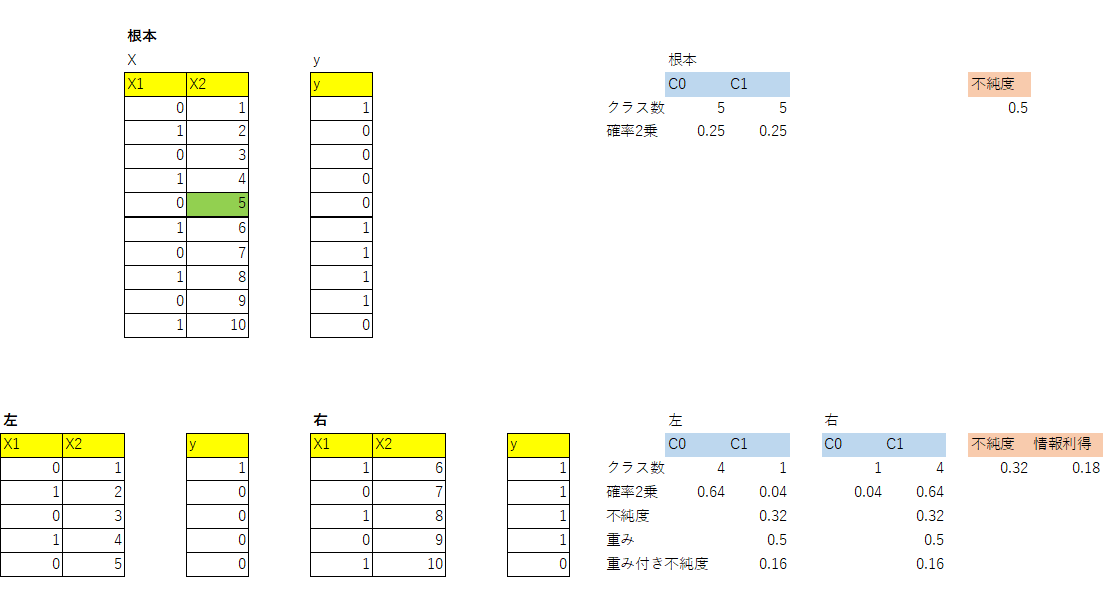

In [7]:
x1 = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
x2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X = np.array([x1, x2]).T
y = np.array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0]).reshape(-1, 1)
print("X", X)
print("y",y)

X [[ 0  1]
 [ 1  2]
 [ 0  3]
 [ 1  4]
 [ 0  5]
 [ 1  6]
 [ 0  7]
 [ 1  8]
 [ 0  9]
 [ 1 10]]
y [[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]]


In [8]:
best_gain = 0

for col in range(X.shape[1]):
    for value in np.unique(X[:, col])[:-1]:
        is_left = (X[:, col] <= value)
        y_left = y[is_left]
        y_right = y[~is_left]
        
        gain = _gain(y_left, y_right)
        
        if gain > best_gain:
            best_gain = gain
            feature_id = col
            threshold = value

print("best_gain:",  best_gain)            
print("feature_id:", feature_id)            
print("threshold:",  threshold)            


best_gain: 0.18000000000000016
feature_id: 1
threshold: 5


## 【問題4】推定
推定する仕組みを実装してください。

ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。

入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。

葉ノードにはクラスが記録されているので、これが推定値となります。

### 【解】クラスの実装を参照

### 【検証】サンプルデータを用いて予測

best_gain: 0.18

feature_id: 1

threshold: 5

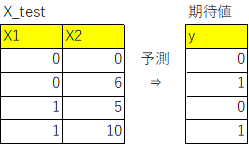

In [9]:
# テストデータ
X_test = np.array([[0, 0, 1 ,1], [0, 6 ,5, 10]]).T
print("test data:\n", X_test)

#モデル定義＆学習
my_tree = ScratchDecesionTreeClassifierDepth1(verbose=True)
my_tree.fit(X, y)

# 予測
pred = my_tree.predict(X_test)
print("predict:", pred)

test data:
 [[ 0  0]
 [ 0  6]
 [ 1  5]
 [ 1 10]]
iter: 1
best_gain: 0.020000000000000018
feature_id: 0
threshold: 0
iter: 2
best_gain: 0.05555555555555558
feature_id: 1
threshold: 1
iter: 3
best_gain: 0.05555555555555558
feature_id: 1
threshold: 1
iter: 4
best_gain: 0.05555555555555558
feature_id: 1
threshold: 1
iter: 5
best_gain: 0.08333333333333331
feature_id: 1
threshold: 4
iter: 6
best_gain: 0.18000000000000016
feature_id: 1
threshold: 5
iter: 7
best_gain: 0.18000000000000016
feature_id: 1
threshold: 5
iter: 8
best_gain: 0.18000000000000016
feature_id: 1
threshold: 5
iter: 9
best_gain: 0.18000000000000016
feature_id: 1
threshold: 5
iter: 10
best_gain: 0.18000000000000016
feature_id: 1
threshold: 5
predict: [0 1 0 1]


## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対して

スクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

#データセットの作成
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#訓練データ、検証データの作成
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [11]:
#学習モデルの作成
my_tree = ScratchDecesionTreeClassifierDepth1(verbose=True)
sk_tree = DecisionTreeClassifier(max_depth=1)

model = {"scratch_model": my_tree, "sklearn_model": sk_tree}
results = pd.DataFrame(columns=["model_name", "accuracy", "precicion", "recall"])
i = 0

for name, model in model.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("*"*20)
    print(name)
    print("predict", y_pred)
    print("answer", y_test)
    
    ac = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    re = recall_score(y_test, y_pred)
    
    results.loc[i, :] = [name, ac, pr, re]
    i += 1

display(results)


iter: 1
best_gain: 0.017241379310344862
feature_id: 0
threshold: -6.6797
iter: 2
best_gain: 0.017241379310344862
feature_id: 0
threshold: -6.6797
iter: 3
best_gain: 0.017241379310344862
feature_id: 0
threshold: -6.6797
iter: 4
best_gain: 0.019230769230769218
feature_id: 0
threshold: -3.1625
iter: 5
best_gain: 0.03600000000000009
feature_id: 0
threshold: -3.1108
iter: 6
best_gain: 0.03600000000000009
feature_id: 0
threshold: -3.1108
iter: 7
best_gain: 0.03600000000000009
feature_id: 0
threshold: -3.1108
iter: 8
best_gain: 0.03600000000000009
feature_id: 0
threshold: -3.1108
iter: 9
best_gain: 0.03600000000000009
feature_id: 0
threshold: -3.1108
iter: 10
best_gain: 0.03600000000000009
feature_id: 0
threshold: -3.1108
iter: 11
best_gain: 0.03600000000000009
feature_id: 0
threshold: -3.1108
iter: 12
best_gain: 0.03600000000000009
feature_id: 0
threshold: -3.1108
iter: 13
best_gain: 0.03600000000000009
feature_id: 0
threshold: -3.1108
iter: 14
best_gain: 0.03600000000000009
feature_id: 0
th

,model_name,accuracy,precicion,recall
0,scratch_model,0.5,0.5,0.4
1,sklearn_model,0.6,0.666667,0.4


## 【問題6】決定領域の可視化
決定領域を可視化してください。

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=[0, 1]):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

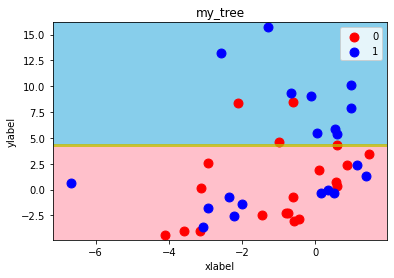

In [13]:
decision_region(X, y, my_tree, title="my_tree")

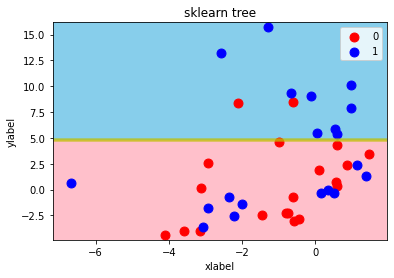

In [14]:
decision_region(X, y, sk_tree, title="sklearn tree")

## 【問題7】深さ2の決定木分類器クラスの作成
深さが2の決定木分類器のクラスScratchDecesionTreeClassifierDepth2を作成してください。

深さ2とは空間の分割を2回行うことを指します。

《ヒント》

各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

## 【問題8】深さに制限のない決定木分類器クラスの作成
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。

任意の深さを指定できるようにするとともに、指定しない場合は全ての葉ノードがジニ不純度0となるまで続けられるようにもしてください。

### 【解】問題７・８をまとめて⇩に記載

In [69]:
class Node():
    """
    ノードを実装
    """
    def __init__(self, class_count, depth):
        self.classes = class_count
        self.depth = depth
        self.feature_id = None
        self.threshold = None
        self.left_node = None
        self.right_node = None
    
    def is_leaf(self):
        return self.feature_id is None

class ScratchDecesionTreeClassifierDepthInf():
    """
    深さ制限なしの決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, max_depth=99999, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.max_depth = max_depth
        self.root_node = None
        
    def fit(self, X, y):
        depth = 0
        X, y = self._data_processing(X, y)
        
        self.classes = np.unique(y)
        self.root_node = self._grow(X, y, depth)
        
        pass
    
    def _grow(self, X, y, depth):
        uniques, counts = np.unique(y, return_counts=True)
        counter = dict(zip(uniques, counts))
        class_count = [counter[c] if c in counter else 0 for c in self.classes]
        
        this = Node(class_count, depth)
        if self._is_leaf(X, y):
            return this
        if self.max_depth == depth:
            return this
        
        left_X, left_y, right_X, right_y, feature_id, threshold = self._branch(X, y)
        
        this.left_node  = self._grow(left_X, left_y, this.depth + 1)
        this.right_node = self._grow(right_X, right_y, this.depth + 1)
        this.feature_id = feature_id
        this.threshold = threshold
        return this
        
    def _branch(self, X, y):
        best_gain = 0
        for col in range(X.shape[1]):
            for value in (X[:, col][1:] + X[:, col][:-1]) / 2:
                is_left = (X[:, col] <= value)
                y_left = y[is_left]
                y_right = y[~is_left]

                gain = _gain(y_left, y_right)

                if gain > best_gain:
                    best_gain = gain
                    feature_id = col
                    threshold = value
                    
        is_left = (X[:, feature_id] <= threshold)
        return X[is_left], y[is_left], X[~is_left], y[~is_left], feature_id, threshold
    
    def _gini(self, y):
        """
        ジニ不純度を計算する
        """
        # 各クラス毎のサンプル数をセット
        _, labels_count = np.unique(y, return_counts=True) #[0, 1, 2], [15, 15, 15]
        labels_count_all = np.sum(labels_count) #45

        impurity = 1 - np.sum((labels_count / labels_count_all)**2)
        return impurity
    
    def _gain(self, y_left, y_right):
        """
        情報利得を計算する
        """
        parent_node = np.concatenate([y_left, y_right])

        num_left, num_right = len(y_left), len(y_right)
        num_all = num_left + num_right

        left_ratio, right_ratio = (num_left / num_all), (num_right / num_all)

        gain = gini(parent_node) - (left_ratio * gini(y_left) + right_ratio * gini(y_right))
        return gain
    
    def _is_leaf(self, X, y):
        is_leaf = (y == y[0]).all() or (X == X[0]).all()
        return is_leaf
    
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        #返り値をリストで初期化
        pred = []
        
        #データの前加工
        X, _ = self._data_processing(X)
        
        for i in range(len(X)):
            node = self.root_node
            while not node.is_leaf():
                is_left = X[i, node.feature_id] <= node.threshold
                node = node.left_node if is_left else node.right_node
            pred_one = np.argmax(node.classes)
            pred.append(pred_one)
        
        pred = np.array(pred)
        return pred
    
    def _data_processing(self, X, y=None):
        # データセットがDataFrame, Seriesの場合ndarrayに変換する
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        
        # データセットが1次元の場合、2次元に変換する
        if X.shape[0] == X.size:
            X = X.reshape(-1, 1)

        return X, y


In [70]:
my_tree = ScratchDecesionTreeClassifierDepthInf()
my_tree.fit(X_train, y_train)
print("my_tree pred:", my_tree.predict(X_test))

sk_tree = DecisionTreeClassifier(random_state=0)
sk_tree.fit(X_train, y_train)
print("sklearn_tree pred:", sk_tree.predict(X_test))

print("y_test:", y_test)

my_tree pred: [1 1 1 0 0 1 0 1 0 1]
sklearn_tree pred: [0 1 1 0 0 1 0 0 0 1]
y_test: [1 1 1 0 0 0 1 0 0 1]


In [75]:
#学習モデルの作成
my_tree_inf = ScratchDecesionTreeClassifierDepthInf()
sk_tree_inf = DecisionTreeClassifier()

model = {"scratch_model": my_tree_inf, "sklearn_model": sk_tree_inf}
results = pd.DataFrame(columns=["model_name", "accuracy", "precicion", "recall"])
i = 0

for name, model in model.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("*"*20)
    print(name)
    print("predict", y_pred)
    print("answer", y_test)
    
    ac = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    re = recall_score(y_test, y_pred)
    
    results.loc[i, :] = [name, ac, pr, re]
    i += 1

display(results)

********************
scratch_model
predict [1 1 1 0 0 1 0 1 0 1]
answer [1 1 1 0 0 0 1 0 0 1]
********************
sklearn_model
predict [1 1 1 0 0 1 0 0 0 1]
answer [1 1 1 0 0 0 1 0 0 1]


,model_name,accuracy,precicion,recall
0,scratch_model,0.7,0.666667,0.8
1,sklearn_model,0.8,0.8,0.8


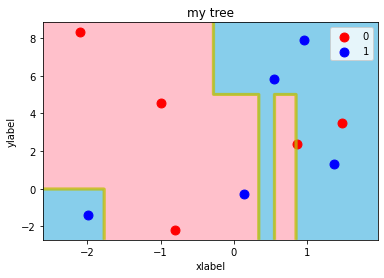

In [78]:
decision_region(X_test, y_test, my_tree_inf, title="my tree")

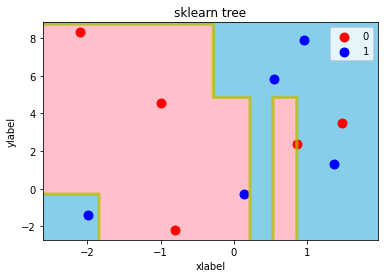

In [79]:
decision_region(X_test, y_test, sk_tree_inf, title="sklearn tree")

【結果】

sklearnに軍配があがる。。。

要因は何なのか。。。

min_leafやmin_sampleは同じ条件だし、max_depthも同じ。

閾値の決定手法も中間値に合わせた

スクラッチとしては満足のいく実装ができたので良しとする